In [1]:
import numpy as np
import msprime
import pandas as pd
import allel

from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import norm

from multiprocessing import Pool, cpu_count

from resample import site_diversity, bt_resample_sites

## Functions to generate simulation and observation

In [2]:
def sim_one_population(diploid_size, seq_len, rec_rate, mut_rate):
    '''simulate two populations that have diverged
        from a common ancestral population.
    Returns a tree sequence.

    @diploid_size = the population size of each population,
        also the size of the ancestral population
    @seq_len = length of the genome, units ~ base-pairs
    @rec_rate = recombination rate, units = rate per bp, per generation
    @mut_rate = mutation rate, units = rate per bp, per generation
    '''

    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=diploid_size)

    ts = msprime.sim_ancestry(
        samples={'A': diploid_size},  # diploid samples
        demography=demography,
        ploidy=2,
        sequence_length=seq_len,
        discrete_genome=False,
        recombination_rate=rec_rate,
        model='dtwf',
    )

    ts = msprime.sim_mutations(
        ts,
        rate=mut_rate,
        discrete_genome=False,
        )

    return ts

In [3]:
def sample_individuals(haploid_indexes, n, replace):
    """
    return the (haploid) indexes that correspond to
    taking n diploid samples from the supplied haploid indexes

    @haploid_indexes = contiguous indexes for haploids
        should be from a single population.
    @n = the number of diploid indiviudals to take.
    """

    # ensure the haploid indexes are consecutive
    diff = np.diff(haploid_indexes)
    assert np.sum(diff == 1) == (len(haploid_indexes)-1)

    ind_indexes = haploid_indexes[::2]
    ind_samples = np.sort(np.random.choice(ind_indexes, n, replace=replace))
    haploid_samples = np.zeros(len(ind_samples)*2, dtype='int')
    haploid_samples[0::2] = ind_samples
    haploid_samples[1::2] = ind_samples+1
    return(haploid_samples)

In [4]:
def observe(ts, num_inds, max_sites):
    '''
    oberserve num_inds diploids from each population
    simplify the ts, removing non-variable sites across those individuals

    @ts = tree-sequence
    @num_inds = number of diploids to sample from each population
    @max_sites = retain at most max_sites, from among variable sites
    '''

    popA = ts.samples(population=0)
    popA_inds = sample_individuals(popA, num_inds, replace=False)
    all_inds = popA_inds
    obs_ts = ts.simplify(samples=all_inds, filter_sites=False)

    if obs_ts.num_sites > max_sites:
        all_sites = np.arange(len(obs_ts.sites()))
        sites_keep = np.random.choice(all_sites, max_sites, replace=False)
        sites_remove = np.setdiff1d(all_sites, sites_keep)
        obs_ts = obs_ts.delete_sites(sites_remove)
    return(obs_ts)

## Functions to caculate the site diversity of samples

In [5]:
def get_diversity_general(ts, samples, sites_index):
    """returns average pairwise diversity of a set of samples across a set of sites. 

    This function is general in the sense that (samples) and (sites_index)may have duplicates.

    @ts = tree sequence
    @samples = the samples from the first population to be used
    @sites_index = the indexes of the sites to be used.
    """
    
    nsamples = len(samples)
    genos = obs_ts.genotype_matrix()
    
    ac = genos[sites_index, :][:,samples].sum(1)
    
    npairs = int(nsamples * (nsamples - 1) / 2)  # total numbers of pairs of samples
    n_different_pairs = ac * (nsamples - ac) # number of those pairs that have different alleles
    
    return (n_different_pairs/npairs).mean()

## Functions to obtain the confidence interval from bootstrap resample

In [6]:
def get_CI_normal(data, confidence, obs_value):
    '''
    @data: estimated parameters (e.g. means of 1000 resample data)
    @confidence: width of the interval
    @est_param: value of the estimated parameter of the data that is resampled
    '''
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = obs_value + qnorm * np.std(data, ddof=1) # change degree of freedom
    lower = obs_value - qnorm * np.std(data, ddof=1)

    return lower, upper


def get_CI_quantile(data, confidence):
    
    cutoff = (1 - confidence) / 2
    lower = np.quantile(data, cutoff)
    upper = np.quantile(data, 1 - cutoff)

    return lower, upper


def get_CI_biased_corrected_norm(data, confidence, obs_value):
    x_bar = mean(data)
    est_bias = x_bar - obs_value
    obs_value -= est_bias
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = obs_value + qnorm * np.std(data, ddof=1)
    lower = obs_value - qnorm * np.std(data, ddof=1)
    
    return lower, upper

## Functions to obtain the confidence interval from jackknife resample

In [7]:
def jk_get_CI(data, confidence):
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = mean(data) + qnorm * np.std(data, ddof=1) / sqrt(len(data)) # change degree of freedom
    lower = mean(data) - qnorm * np.std(data, ddof=1) / sqrt(len(data))

    return lower, upper

## Functions to draw plots

In [8]:
def histplot(data, pop_value, obs_value, normal, quantile, biased):
    '''
    Display the histogram of the site diversity of the resampled data and draw lines of 
    population site diversity, observed population site diversity, and three different CI.
    '''
    fig = plt.figure(dpi=180)
    sns.histplot(data)
    plt.axvline(x=obs_value, color = 'r', label = 'observe')
    plt.axvline(x=pop_value, color = 'g', label = 'pop')
    plt.axvline(x=normal[0], color = 'b', label = 'normal')
    plt.axvline(x=normal[1], color = 'b')
    plt.axvline(x=quantile[0], color = 'm', label = 'quantile')
    plt.axvline(x=quantile[1], color = 'm')
    plt.axvline(x=biased[0], color = 'y', label = 'biased corrected')
    plt.axvline(x=biased[1], color = 'y')
    plt.legend(loc='best', fontsize = 'xx-small')
    plt.xlabel('Estimate site diversity of the resampled observed population')
    plt.show()
    

def jk_histplot(data, pop_value, obs_value, jk_CI, jk_block_CI):
    fig2 = plt.figure(dpi=150)
    sns.histplot(data)
    plt.axvline(x=obs_value, color = 'r', label = 'observe')
    plt.axvline(x=pop_value, color = 'g', label = 'pop')
    plt.axvline(x=jk_CI[0], color = 'y', label = 'jackknife CI')
    plt.axvline(x=jk_CI[1], color = 'y')
    plt.axvline(x=jk_block_CI[0], color = 'm', label = 'jackknife block CI')
    plt.axvline(x=jk_block_CI[1], color = 'm')
    plt.legend(loc=0)
    plt.title('Histogram of site diversity from Jackknife Resample')
    plt.show()

# We observe 50 individuals and at most 5000 sites from the population and we want to use different resample methods and the observed population to estimate the site diversity of the whole population.

In [9]:
# simulation of the entire demographic history
pop_ts = sim_one_population(
    diploid_size=200,
    seq_len=1e9,
    rec_rate=1e-8,
    mut_rate=1e-8
)

obs_ts = observe(ts=pop_ts, num_inds=50, max_sites=5000)

In [10]:
pop_ts.num_samples, pop_ts.num_sites

(400, 52768)

In [11]:
obs_ts.num_samples, obs_ts.num_sites

(100, 5000)

In [12]:
pop_ts_diversity = pop_ts.diversity(span_normalise = False, windows = 'sites').mean()

obs_ts_diversity = obs_ts.diversity(span_normalise = False, windows = 'sites').mean()

print('Site diversity for the simulated population is: ', pop_ts_diversity)
print('Site diversity for the observed population is: ', obs_ts_diversity)

Site diversity for the simulated population is:  0.15081724075957023
Site diversity for the observed population is:  0.152544


In [13]:
obs_ts.genotype_matrix().shape

(5000, 100)

In [14]:
# site diversity for the observed population
diversity = site_diversity(obs_ts)
diversity

array([0.48868687, 0.03959596, 0.11393939, ..., 0.50505051, 0.        ,
       0.39818182])

## 1. Bootstrap over sites

In [166]:
%%time
# use numpy array to speed up the bootstrap process
bt_weights = np.random.multinomial(
    n=obs_ts.num_sites,
    pvals=np.ones(obs_ts.num_sites) / obs_ts.num_sites,
    size=5000
)

bt_val = np.mean((diversity * bt_weights), axis=1)

CPU times: user 1.54 s, sys: 208 ms, total: 1.75 s
Wall time: 1.86 s


In [167]:
sites_normal = get_CI_normal(data=bt_val, confidence=0.95, obs_value=obs_ts_diversity)
sites_quantile = get_CI_quantile(data=bt_val, confidence=0.95)
sites_biased = get_CI_biased_corrected_norm(data=bt_val, confidence=0.95, obs_value=obs_ts_diversity)

In [168]:
print('Normal CI', sites_normal, '\n')
print('Quantile CI', sites_quantile, '\n')
print('Biased Corrected Normal CI', sites_biased, '\n')

Normal CI (0.13999683134210242, 0.14928793633466528) 

Quantile CI (0.13991165757575758, 0.14928341212121213) 

Biased Corrected Normal CI (0.14001725990775898, 0.14930836490032184) 



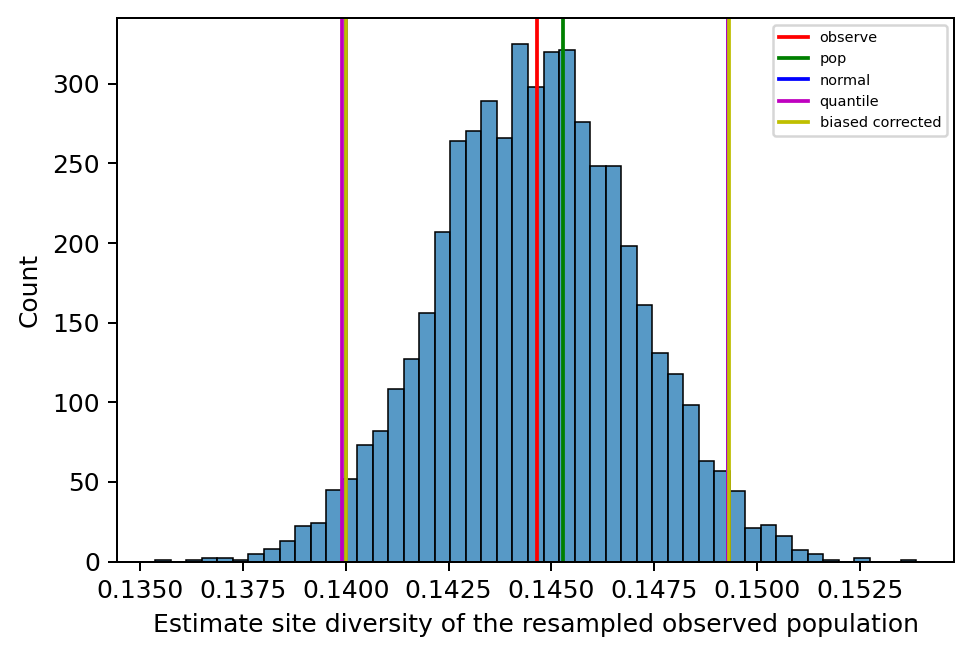

In [169]:
histplot(data=bt_val, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         normal=sites_normal, quantile=sites_quantile, biased=sites_biased)

## 2. Bootstrap over samples 

In [109]:
%%time
bt_sample_res = [
    get_diversity_general(
        ts=obs_ts,
        samples=np.random.choice(obs_ts.num_samples, obs_ts.num_samples, replace = True),
        sites_index=np.arange(obs_ts.num_sites)) for _ in range(5000)]

CPU times: user 5min 34s, sys: 4 s, total: 5min 38s
Wall time: 5min 46s


In [110]:
sample_normal = get_CI_normal(data=bt_sample_res, confidence=0.95, obs_value=obs_ts_diversity)
sample_quantile = get_CI_quantile(data=bt_sample_res, confidence=0.95)
sample_biased = get_CI_biased_corrected_norm(data=bt_sample_res, confidence=0.95, obs_value=obs_ts_diversity)

In [111]:
print('Normal CI', sample_normal, '\n')
print('Quantile CI', sample_quantile, '\n')
print('Biased Corrected Normal CI', sample_biased, '\n')

Normal CI (0.15035025577241648, 0.15133648794617646) 

Quantile CI (0.1495673447236181, 0.15055639918341707) 

Biased Corrected Normal CI (0.15111265331312, 0.15209888548687997) 



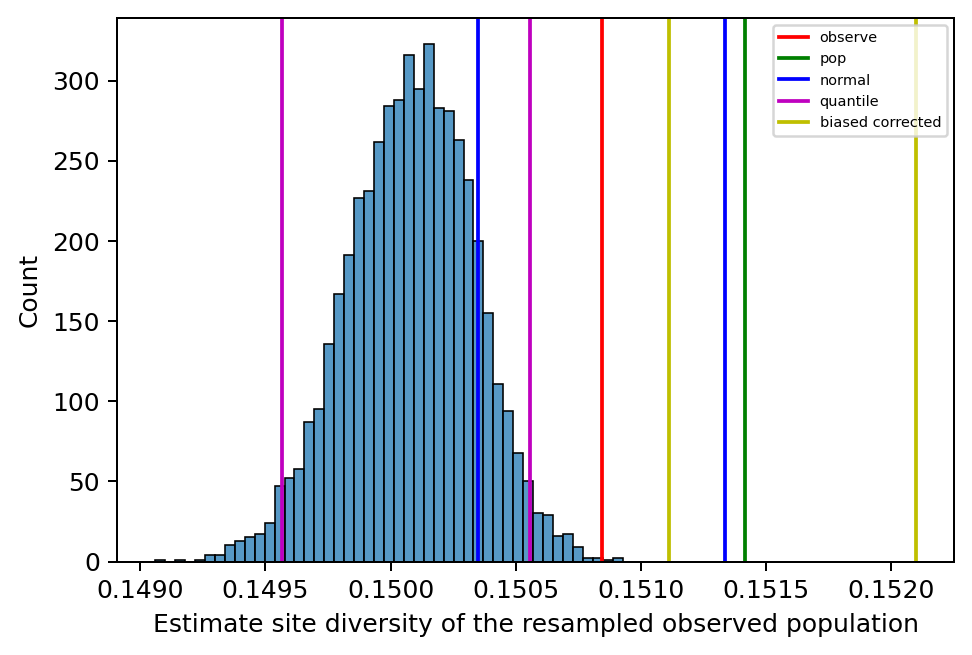

In [113]:
histplot(data=bt_sample_res, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         normal=sample_normal, quantile=sample_quantile, biased=sample_biased)

## 3. Jackknife over sites

In [15]:
%%time
# try to speed up the jackknife process
jk_weights = np.ones((obs_ts.num_sites, obs_ts.num_sites), dtype=int)
np.fill_diagonal(jk_weights, 0)

jk_val = (diversity * jk_weights).sum(axis=1) / (obs_ts.num_sites - 1)

CPU times: user 187 ms, sys: 185 ms, total: 372 ms
Wall time: 745 ms


In [16]:
jk_weights

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [17]:
jk_weights.shape

(5000, 5000)

In [18]:
# diversity by deleting one site
jk_val

array([0.15247676, 0.15256659, 0.15255172, ..., 0.15247348, 0.15257451,
       0.15249486])

<AxesSubplot:ylabel='Count'>

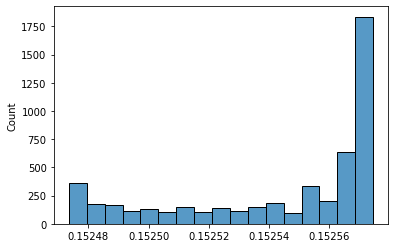

In [19]:
sns.histplot(jk_val)

In [20]:
jk_pse_val = obs_ts.num_sites * obs_ts_diversity - (obs_ts.num_sites - 1) * jk_val

In [21]:
jk_pse_val

array([0.48868687, 0.03959596, 0.11393939, ..., 0.50505051, 0.        ,
       0.39818182])

In [22]:
sum(jk_pse_val > 0.5)

139

<AxesSubplot:ylabel='Count'>

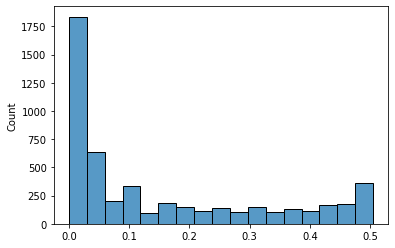

In [23]:
sns.histplot(jk_pse_val)

In [24]:
# jackknife block
n_fold = obs_ts.num_sites // 100
num_sites = len(diversity)
jk_block_weights = np.ones((n_fold, num_sites), dtype=int)
kf = KFold(n_splits=n_fold)
    
# fill deleleted block with 0
for i, (_, zero_index) in enumerate(kf.split(np.arange(num_sites))):
    jk_block_weights[i][zero_index] = 0

In [25]:
jk_block_weights

array([[0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]])

In [28]:
(jk_block_weights == 1).sum(axis=1)

array([4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900,
       4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900,
       4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900,
       4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900,
       4900, 4900, 4900, 4900, 4900, 4900])

<AxesSubplot:ylabel='Count'>

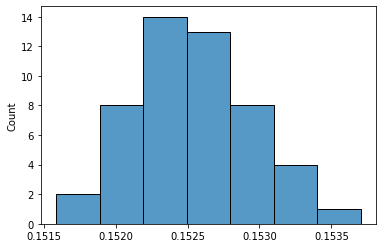

In [29]:
jk_block_val = (diversity * jk_block_weights).sum(axis=1) / ((jk_block_weights == 1).sum(axis=1))
sns.histplot(jk_block_val)

<AxesSubplot:ylabel='Count'>

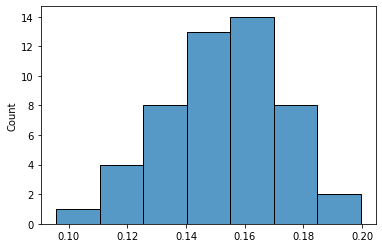

In [30]:
jk_block_pse = n_fold * obs_ts_diversity - (n_fold - 1) * jk_block_val
sns.histplot(jk_block_pse)

In [31]:
jk_sites_CI = jk_get_CI(data=jk_pse_val, confidence=0.95)
jk_block_sites_CI = jk_get_CI(data=jk_block_pse, confidence=0.95)
print('Jackknife CI', jk_sites_CI, '\n')
print('Block Jackknife CI', jk_block_sites_CI, '\n')

Jackknife CI (0.14783701852862868, 0.15725098147138117) 

Block Jackknife CI (0.14691928636025714, 0.15816871363974266) 



In [33]:
jk_histplot(data=jk_block_pse, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         jk_CI=jk_sites_CI, jk_block_CI=jk_block_sites_CI)

NameError: name 'jk_block_pse_val' is not defined

#### Why are there so much 0s?

## 4. Jackknife over samples

In [34]:
jk_sample_res = []
for i in range(obs_ts.num_samples):
    leave_one_out = get_diversity_general(
        ts=obs_ts,
        samples=np.delete(samples_index, i),
        sites_index=sites_index
    )
    jk_sample_res.append(n_samples * obs_ts_diversity - (n_samples - 1) * leave_one_out)

In [35]:
jk_block_sample_res = []
n_fold = 20
kf = KFold(n_splits=n_fold) # 10 sites in each block, total 200 samples

for index,_ in kf.split(samples_index):
    leave_one_out = get_diversity_general(
        ts=obs_ts,
        samples=samples_index[index],
        sites_index=sites_index
    )
    
    jk_block_sample_res.append(n_fold * obs_ts_diversity - (n_fold - 1) * leave_one_out)

In [36]:
jk_sample_CI = jk_get_CI(data=jk_sample_res, confidence=0.95)
jk_block_sample_CI = jk_get_CI(data=jk_block_sample_res, confidence=0.95)
print('Jackknife CI', jk_sample_CI, '\n')
print('Block Jackknife CI', jk_block_sample_CI, '\n')

Jackknife CI (0.15479720942487962, 0.15671616431249713) 

Block Jackknife CI (0.1547334541537527, 0.15669265889159414) 



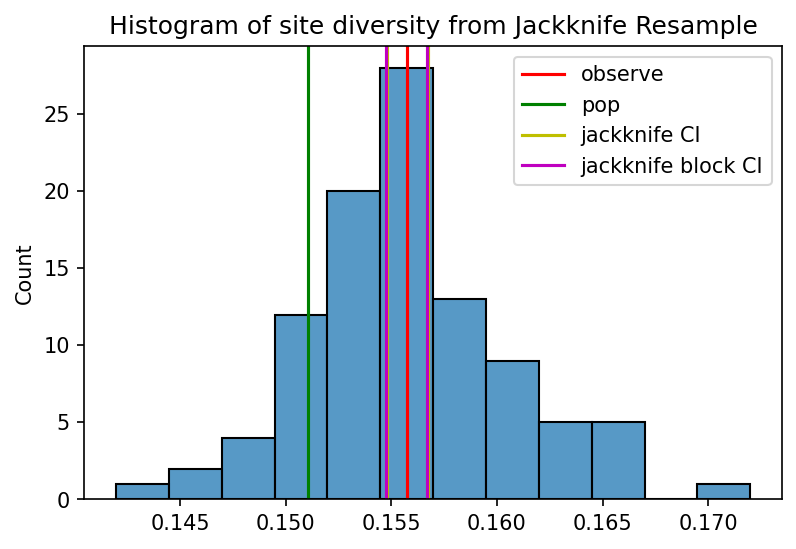

In [37]:
jk_histplot(data=jk_sample_res, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         jk_CI=jk_sample_CI, jk_block_CI=jk_block_sample_CI)

## Now, with the much fast bootstrapping methods, we will try to find the coverage rate for the current observed population. A.K.A: how likely will the confidence interval include the population site diversity?

In [75]:
pop_ts_diversity

0.14900405826281182

In [170]:
%%time
if __name__ ==  '__main__': 
    res = []
    n_boot = 1000
    
    coverage_rate = {'normal': np.zeros((500, ), dtype=int), 'quantile': np.zeros((500, ), dtype=int)
                , 'bias': np.zeros((500, ), dtype=int)}
    lower = {'normal': [], 'quantile': [], 'bias': []}
    upper = {'normal': [], 'quantile': [], 'bias': []}

    diveristy = site_diversity(obs_ts)
    inputs = [(diveristy, n_boot) for _ in range(500)]
    pool = Pool(4)
    
    print('Process begins')
    
    for i, bt_vals in enumerate(pool.map(bt_resample_sites, inputs)):
        res.append(bt_vals)
        normal_lower, normal_upper = \
                get_CI_normal(data=bt_vals, confidence=0.95, obs_value=obs_ts_diversity)
    
        quantile_lower, quantile_upper = get_CI_quantile(data=bt_vals, confidence=0.95)
    
        bias_lower, bias_upper = \
                get_CI_biased_corrected_norm(data=bt_vals, confidence=0.95, obs_value=obs_ts_diversity)
        
        lower['normal'].append(normal_lower)
        upper['normal'].append(normal_upper)

        lower['quantile'].append(quantile_lower)
        upper['quantile'].append(quantile_upper)

        lower['bias'].append(bias_lower)
        upper['bias'].append(bias_upper)

    
        if normal_lower < pop_ts_diversity < normal_upper:
            coverage_rate['normal'][i] = 1

        if quantile_lower < pop_ts_diversity < quantile_upper:
            coverage_rate['quantile'][i] = 1

        if bias_lower < pop_ts_diversity < bias_upper:
            coverage_rate['bias'][i] = 1
        
    print('Process ends')


Process begins
Process ends
CPU times: user 1.31 s, sys: 74.9 ms, total: 1.38 s
Wall time: 1min 2s


1000


<AxesSubplot:ylabel='Count'>

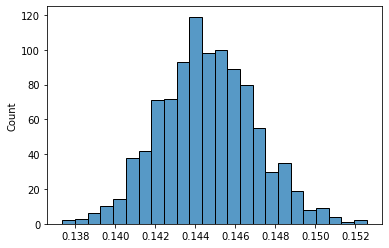

In [171]:
print(len(res[0]))
sns.histplot(res[0])

In [172]:
df = pd.DataFrame.from_dict(coverage_rate)
df

,normal,quantile,bias
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
495,1,1,1
496,1,1,1
497,1,1,1
498,1,1,1


In [173]:
df.describe().iloc[1]

normal      1.0
quantile    1.0
bias        1.0
Name: mean, dtype: float64

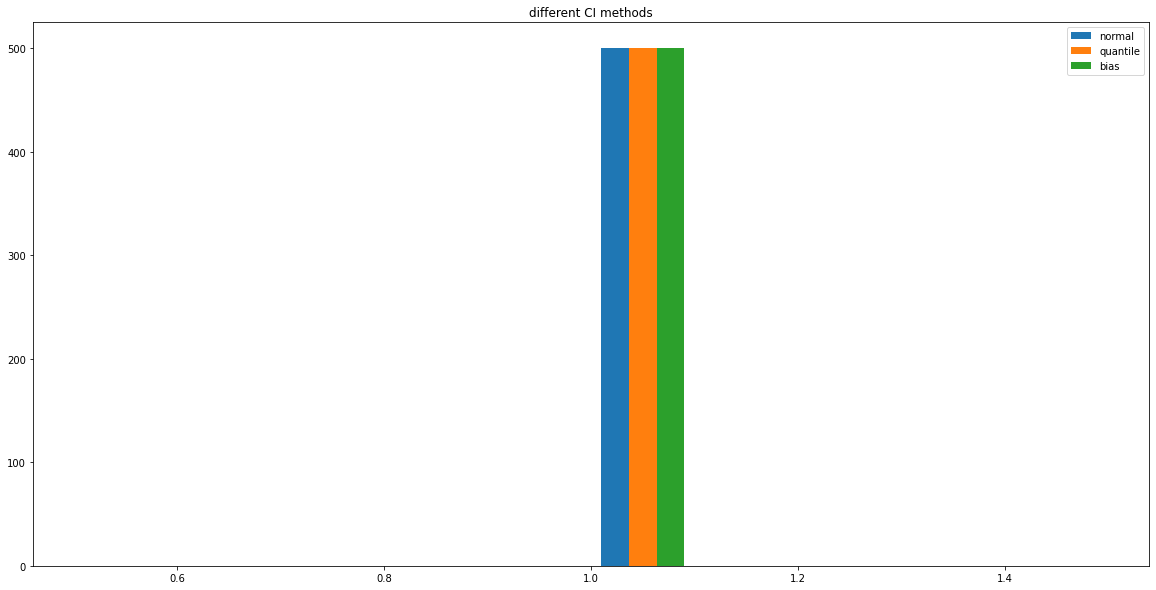

In [174]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(df, histtype='bar')
ax.set_title('different CI methods')
ax.legend(list(df.columns))

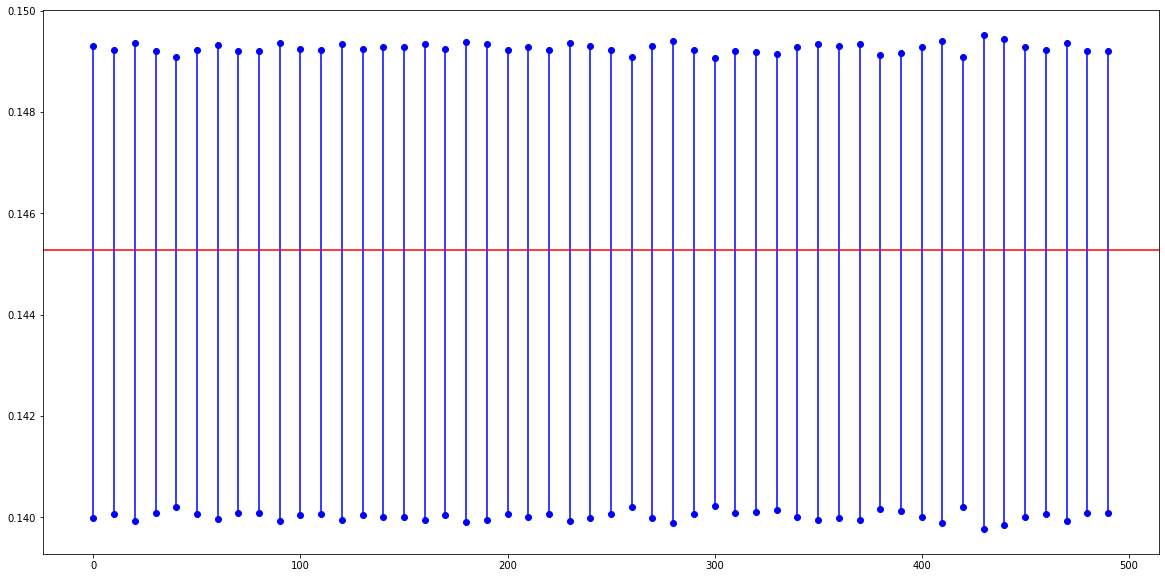

In [175]:
fig, ax = plt.subplots(figsize=(20, 10))
for i, (y1, y2) in enumerate(zip(lower['normal'], upper['normal'])):
    if i % 10 == 0:
        ax.plot((i, i), (y1, y2), 'o-', color='b')

ax.axhline(pop_ts_diversity, xmin = 0, xmax = 500, color = 'r')

# Next Step (Aug. 15): Try to increase the sample size and the sites size of the observed population.

In [176]:
samples_size = np.linspace(10, 50, 11, dtype=int)
sites_size = np.linspace(1000, 5000, 11, dtype=int)

In [177]:
samples_size 

array([10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50])

In [178]:
sites_size

array([1000, 1400, 1800, 2200, 2600, 3000, 3400, 3800, 4200, 4600, 5000])

In [187]:
%%time
if __name__ ==  '__main__': 
    pop_ts = sim_one_population(
        diploid_size=200,
        seq_len=1e9,
        rec_rate=1e-8,
        mut_rate=1e-8
    )
    
    pop_ts_diversity = pop_ts.diversity(span_normalise = False, windows = 'sites').mean()
    n_boot = 100
    
    sim = []
    
    for num_inds in samples_size:
        for num_sites in sites_size:
            obs_ts = observe(ts=pop_ts, num_inds=num_inds, max_sites=num_sites)
            obs_ts_diversity = obs_ts.diversity(span_normalise = False, windows = 'sites').mean()

            print(f'The shape of observed population (inds, sites) is: {(num_inds, num_sites)} \n')
            print(f'The population site diveristy is: {pop_ts_diversity}')
            print(f'The observed site diveristy is: {obs_ts_diversity} \n')
            
            diveristy = site_diversity(obs_ts)
            # repeat bootstrap resampling 500 times
            inputs = [(diveristy, n_boot) for _ in range(500)]
            pool = Pool(cpu_count())

            coverage_rate = {'normal': np.zeros((500, ), dtype=int), 'quantile': np.zeros((500, ), dtype=int)
                            , 'bias': np.zeros((500, ), dtype=int)}

            for i, bt_vals in enumerate(pool.map(bt_resample_sites, inputs)):
                normal_lower, normal_upper = \
                        get_CI_normal(data=bt_vals, confidence=0.95, obs_value=obs_ts_diversity)

                quantile_lower, quantile_upper = get_CI_quantile(data=bt_vals, confidence=0.95)

                bias_lower, bias_upper = \
                        get_CI_biased_corrected_norm(data=bt_vals, confidence=0.95, obs_value=obs_ts_diversity)
                
                if normal_lower < pop_ts_diversity < normal_upper:
                    coverage_rate['normal'][i] = 1

                if quantile_lower < pop_ts_diversity < quantile_upper:
                    coverage_rate['quantile'][i] = 1

                if bias_lower < pop_ts_diversity < bias_upper:
                    coverage_rate['bias'][i] = 1
                

            print('Coverage Rate')
            print('    Normal:', coverage_rate['normal'].mean())
            print('    Quantile:', coverage_rate['quantile'].mean())
            print('    Biased_corrected_normal:', coverage_rate['bias'].mean(), '\n')

            sim.append([num_inds, num_sites, pop_ts_diversity, obs_ts_diversity, 
                        coverage_rate['normal'].mean(), coverage_rate['quantile'].mean(),
                        coverage_rate['bias'].mean()])
            #break
        #break

The shape of observed population (inds, sites) is: (10, 1000) 

The population site diveristy is: 0.14983892226715867
The observed site diveristy is: 0.1585 

Coverage Rate
    Normal: 0.998
    Quantile: 0.926
    Biased_corrected_normal: 0.99 

The shape of observed population (inds, sites) is: (10, 1400) 

The population site diveristy is: 0.14983892226715867
The observed site diveristy is: 0.15612781954887217 

Coverage Rate
    Normal: 1.0
    Quantile: 1.0
    Biased_corrected_normal: 1.0 

The shape of observed population (inds, sites) is: (10, 1800) 

The population site diveristy is: 0.14983892226715867
The observed site diveristy is: 0.14884795321637428 

Coverage Rate
    Normal: 1.0
    Quantile: 1.0
    Biased_corrected_normal: 1.0 

The shape of observed population (inds, sites) is: (10, 2200) 

The population site diveristy is: 0.14983892226715867
The observed site diveristy is: 0.1571626794258373 

Coverage Rate
    Normal: 0.772
    Quantile: 0.54
    Biased_corrected_

In [192]:
sim_df = pd.DataFrame(sim)
sim_df.columns = ['n_inds', 'n_sites', 'pop_ts_diversity', 'obs_ts_diversity', 'normal', 'quantile', 'bias']
sim_df

,n_inds,n_sites,pop_ts_diversity,obs_ts_diversity,normal,quantile,bias
0,10,1000,0.149839,0.158500,0.998,0.926,0.990
1,10,1400,0.149839,0.156128,1.000,1.000,1.000
2,10,1800,0.149839,0.148848,1.000,1.000,1.000
3,10,2200,0.149839,0.157163,0.772,0.540,0.706
4,10,2600,0.149839,0.153016,1.000,1.000,1.000
...,...,...,...,...,...,...,...
116,50,3400,0.149839,0.149821,1.000,1.000,1.000
117,50,3800,0.149839,0.149347,1.000,1.000,1.000
118,50,4200,0.149839,0.147068,1.000,1.000,1.000
119,50,4600,0.149839,0.150980,1.000,1.000,1.000


In [198]:
(len(samples_size), len(sites_size))

(11, 11)

In [203]:
rate = np.reshape(np.array(sim_df['normal']), (len(samples_size), len(sites_size)))
rate

array([[0.998, 1.   , 1.   , 0.772, 1.   , 0.578, 1.   , 1.   , 1.   ,
        0.766, 1.   ],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [0.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [1.   , 1.   , 1.   , 1.   , 0.4  , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [1.   , 1.   , 0.7  , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [1.   , 1.   , 1.   , 0.486, 1.   , 1.   , 1.   , 1.   , 1.   ,
        0.004, 1.   ],
       [1.   , 1.   , 0.98 , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [1.   , 1.   , 0.894, 1.   , 0.348, 1.   , 1.   , 0.008, 1.   ,
        1.   , 1.   ],
       [0.966, 1.   , 0.998, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.062, 0.998,
        1.   , 1.   ],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1. 

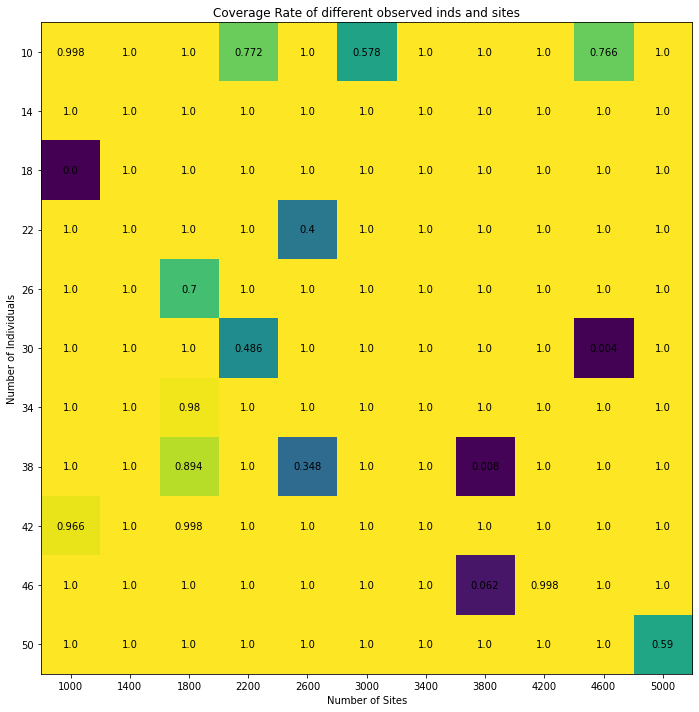

In [212]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(rate)

# We want to show all ticks...
ax.set_xticks(np.arange(len(sites_size)))
ax.set_yticks(np.arange(len(samples_size)))
# ... and label them with the respective list entries
ax.set_xticklabels(sites_size)
ax.set_yticklabels(samples_size)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), ha="right")

# Loop over data dimensions and create text annotations.
for i in range(len(sites_size)):
    for j in range(len(samples_size)):
        text = ax.text(j, i, rate[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Coverage Rate of different observed inds and sites")
ax.set_ylabel('Number of Individuals')
ax.set_xlabel('Number of Sites')
fig.tight_layout()
plt.show()

 ## Problems
 ### 1. The slow way of doing jackknife resampling gives too much 0 psedovalues.
 ### 2. The faster way of doing jackknife resampling gives the values that are larger than 0.5.
 ### 3. Jackknife gives values that are much greater than the population value.
 ### 4. Results are too random.

In [137]:
diversity = get_site_diversity(obs_ts)

In [177]:
jk_sites = jk_resample_sites(diversity, obs_ts.num_sites, obs_ts_diversity)

In [178]:
jk_sites

array([0.30441382, 0.15575669, 0.32117814, ..., 0.38419584, 0.38419584,
       0.17575269])

<AxesSubplot:ylabel='Count'>

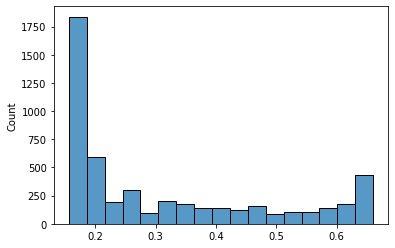

In [179]:
sns.histplot(jk_sites)

In [180]:
jk_block_sits = jk_block_resample_sites(diversity, obs_ts_diversity, obs_ts.num_sites, 50)

In [181]:
jk_block_sits

array([0.30299822, 0.31211321, 0.31931572, 0.31933354, 0.32417612,
       0.30726865, 0.3012857 , 0.30235875, 0.32219236, 0.32595398,
       0.31865051, 0.28959499, 0.27670848, 0.27467127, 0.29313289,
       0.34050352, 0.28310521, 0.31538582, 0.3108204 , 0.283616  ,
       0.29243798, 0.30804275, 0.31710032, 0.31156085, 0.31779523,
       0.29186582, 0.29471079, 0.27960889, 0.27464158, 0.31073923,
       0.29308537, 0.29925046, 0.33423547, 0.32522739, 0.33855539,
       0.28628081, 0.27822501, 0.32051745, 0.30450089, 0.33800105,
       0.3457678 , 0.30852186, 0.28281814, 0.32298428, 0.29422178,
       0.32742497, 0.33122816, 0.30691228, 0.30803285, 0.3524318 ])

<AxesSubplot:ylabel='Count'>

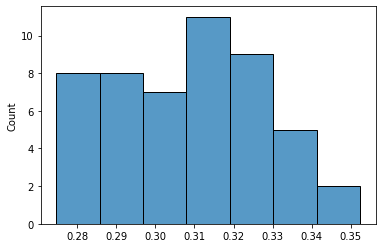

In [182]:
sns.histplot(jk_block_sits)